# Attempt GPU computation with mlx
`mlx` implements numpy-like numerical computing for apple silicon. As of `mlx` 0.13, missing features including `searchsorted` and `quantiles` prevent its use for `persistence_spectrum` and `amplitude_probability_distribution`, but the other analyses work.

### Generate fake data

In [1]:
from edge_analysis import channel_waveform
from scipy import signal
from edge_analysis.io import simulated_awgn

duration = 4
sample_rate_Hz = 14e6
analysis_bandwidth_Hz = 10e6

raw_iq = simulated_awgn(duration, sample_rate_Hz)

### Analysis bandpass filter

In [2]:
%timeit -n1 -r1

filter_params = dict(
    passband_ripple_dB=0.1,
    stopband_attenuation_dB=70,
    transition_bandwidth_Hz=250e3,
)

sos = channel_waveform.generate_iir_lpf(
    cutoff_Hz=analysis_bandwidth_Hz / 2, sample_rate_Hz=sample_rate_Hz, **filter_params
).astype('float32')

iq_cpu = signal.sosfilt(sos, raw_iq)

In [3]:
import mlx.core as mx

iq_gpu = mx.array(iq_cpu)

### Channel power time-series

In [4]:
pvt = channel_waveform.power_time_series(
    iq_gpu,
    sample_rate_Hz=sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    detector_period=10e-3,
    detectors=('rms', 'peak'),
)

In [5]:
%%timeit -n1 -r1

channel_waveform.power_time_series(
    iq_gpu,
    sample_rate_Hz=sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    detector_period=10e-3,
    detectors=('rms', 'peak'),
)

14.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


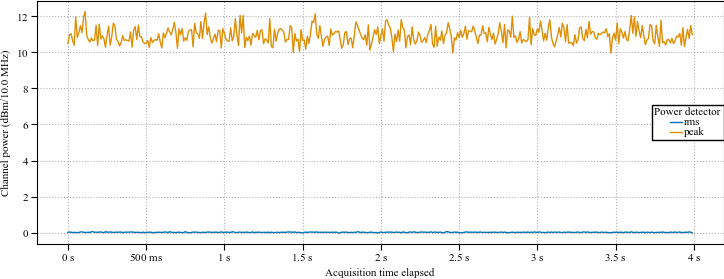

In [6]:
from iqwaveform import powtodB
from matplotlib import pyplot as plt
from edge_analysis import figures

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()

pvt.plot.line(x='time_elapsed', ax=ax)

figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

### Cyclic channel power

In [7]:
cyclic_power = channel_waveform.cyclic_channel_power(
    iq_gpu,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    cyclic_period=10e-3,
    detector_period=1e-3 / 14 / 4,
    detectors=('rms', 'peak'),
    cyclic_statistics=('min', 'mean', 'max'),
)

In [8]:
%%timeit -n1 -r1
print('GPU execution')
cyclic_power = channel_waveform.cyclic_channel_power(
    iq_gpu,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    cyclic_period=10e-3,
    detector_period=1e-3 / 14 / 4,
    detectors=pvt.power_detector.values,
    cyclic_statistics=('min', 'mean', 'max'),
)

GPU execution
19 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
%%timeit -n1 -r1
print('CPU execution')
cyclic_power = channel_waveform.cyclic_channel_power(
    iq_cpu,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    cyclic_period=10e-3,
    detector_period=1e-3 / 14 / 4,
    detectors=pvt.power_detector.values,
    cyclic_statistics=('min', 'mean', 'max'),
)

CPU execution
369 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


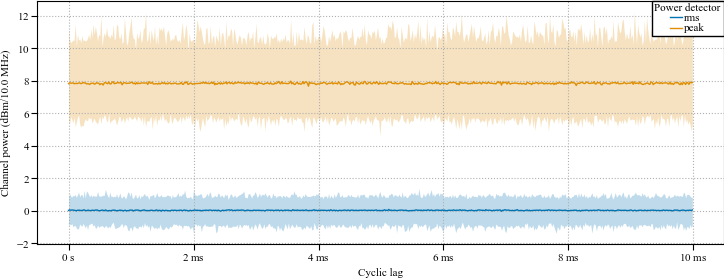

In [10]:
fig, ax = plt.subplots()

time = cyclic_power.cyclic_lag

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.plot(time, powtodB(a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.fill_between(
        time,
        powtodB(a.sel(cyclic_statistic='min')),
        powtodB(a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

### Persistence Spectrum

In [11]:
frequency_resolution = 16e3
spectrum_quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1]

spectrum = channel_waveform.persistence_spectrum(
    iq_gpu,
    sample_rate_Hz=sample_rate_Hz,
    window='flattop',
    resolution=frequency_resolution,
    quantiles=spectrum_quantiles,
)
spectrum

<module 'mlx.core' from '/opt/homebrew/Caskroom/mambaforge/base/envs/spectrum-sensor-edge-analysis/lib/python3.9/site-packages/mlx/core.cpython-39-darwin.so'> <class 'mlx.core.array'>
<class 'mlx.core.array'> <class 'mlx.core.array'> <class 'mlx.core.array'> <module 'mlx.core' from '/opt/homebrew/Caskroom/mambaforge/base/envs/spectrum-sensor-edge-analysis/lib/python3.9/site-packages/mlx/core.cpython-39-darwin.so'>
<class 'mlx.core.array'>


AttributeError: module 'mlx.core.fft' has no attribute 'fftshift'

In [ ]:
%%timeit -n1 -r1
spectrum = channel_waveform.persistence_spectrum(
    iq_gpu,
    sample_rate_Hz=sample_rate_Hz,
    window='flattop',
    resolution=frequency_resolution,
    quantiles=spectrum_quantiles,
)

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <module 'array_api_compat.torch' from '/opt/homebrew/Caskroom/mambaforge/base/envs/spectrum-sensor-edge-analysis/lib/python3.9/site-packages/array_api_compat/torch/__init__.py'>
<class 'torch.Tensor'>
96.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


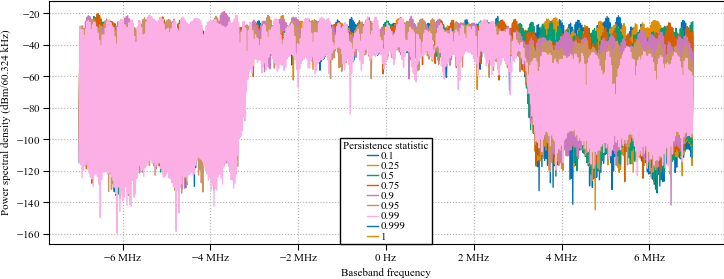

In [ ]:
fig, ax = plt.subplots()

spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
figures.label_axis(ax.yaxis, spectrum, tick_units=False)
figures.label_legend(ax, spectrum, 'persistence_statistic')

### Amplitude Probability Distribution

In [12]:
apd_bins = dict(power_low=-40., power_high=15., power_count=55 * 4 + 1)

apd = channel_waveform.amplitude_probability_distribution(
    iq_gpu, analysis_bandwidth_Hz=analysis_bandwidth_Hz, **apd_bins
)

AttributeError: module 'mlx.core' has no attribute 'searchsorted'

In [ ]:
%%timeit -n1 -r1
apd = channel_waveform.amplitude_probability_distribution(
    iq_gpu, analysis_bandwidth_Hz=analysis_bandwidth_Hz, **apd_bins
)